In [14]:
import pandas as pd
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import traceback
from pathlib import Path
import os

In [15]:
from onee.utils import create_monthly_matrix, plot_var_over_time, calculate_all_metrics, custom_mean_absolute_percentage_error
from onee.data.loader import DataLoader

In [16]:
PROJECT_ROOT = Path(os.getcwd()).resolve().parents[0]

In [17]:
data_loader = DataLoader(PROJECT_ROOT)

In [18]:
df_regional, df_features, df_dist, var_cols = data_loader.load_srm_data(
    db_path=PROJECT_ROOT / "data" / "all_data.db",
    variable="consommation_kwh",
    target_region="Casablanca-Settat",
)

In [19]:
df_regional

,annee,mois,activite,consommation_kwh
0,2007,1,Administratif,3.157306e+04
1,2007,1,Force_Motrice_Agricole,8.933921e+05
2,2007,1,Force_Motrice_Industrielle,2.180512e+06
3,2007,1,Menages,3.032363e+07
4,2007,1,Patentes,4.660222e+06
...,...,...,...,...
1015,2023,12,Administratif_mt,1.268492e+07
1016,2023,12,Agricole,1.028805e+07
1017,2023,12,Industriel,1.339789e+08
1018,2023,12,Résidentiel,1.752242e+07


## Config

In [20]:
ALPHAS = [0.01, 0.1, 1.0, 10.0]
R2_THRESHOLD = 0.6

# PCA plots

In [21]:
# fpca_monthly_pca_dual.py
# ---------------------------------------------------------
# Regular PCA on monthly curves (12 months) per year (2018–2023), per contract,
# applied to both variables: "ventes" and "consomation".
# Produces mean + 3 PCA components for each contract and each variable.
# Output: Combined long-form CSV with both variables.
# ---------------------------------------------------------

import os
import sys
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# ---------------------- Configuration ----------------------
OUTPUT_CSV = "fpca_pca_results_both.csv"

YEARS = list(range(2013, 2023))
MONTHS = list(range(1, 13))
N_COMPONENTS = 3
VARIABLES = ["consommation_kwh"]

ANNEE = "annee"
MOIS = "mois"
ENTITY = "activite"

# -----------------------------------------------------------

def run_pca_on_matrix(X , n_components: int = 3):
    """Run PCA on 12 monthly values (columns)."""
    mean_curve = np.nanmean(X, axis=0)
    scaler = StandardScaler()
    X_std = scaler.fit_transform(X)
    n_allowed = min(n_components, X_std.shape[0], X_std.shape[1])
    pca = PCA(n_components=n_allowed)
    pca.fit(X_std)
    components = [pca.components_[i, :].copy() for i in range(n_allowed)]
    explained_var_ratio = pca.explained_variance_ratio_.copy()

    # pad if fewer components possible
    while len(components) < n_components:
        components.append(np.full(X_std.shape[1], np.nan))
        explained_var_ratio = np.append(explained_var_ratio, np.nan)

    return mean_curve, components, explained_var_ratio

def run_fpca_for_all(df, output_csv=OUTPUT_CSV):

    df[ANNEE] = df[ANNEE].astype(int)
    df[MOIS] = df[MOIS].astype(int)
    df = df[df[ANNEE].isin(YEARS)]

    results = []
    contracts = df[ENTITY].dropna().unique()
    processed = 0
    skipped = 0

    for c in contracts:
        df_c = df[df[ENTITY] == c]
        contract_ok = False

        for var in VARIABLES:
            if var not in df.columns:
                print(f"[WARNING] Missing variable '{var}' in dataset — skipping.")
                continue

            M = create_monthly_matrix(df_c, var)

            mean_curve, components, exp_var_ratio = run_pca_on_matrix(M, N_COMPONENTS)

            # store mean + components
            for m_idx, month in enumerate(MONTHS):
                results.append({
                    "contrat": c, "variable": var, "component": "mean",
                    "month": month, "value": float(mean_curve[m_idx]),
                    "explained_variance_ratio": np.nan
                })
            for k in range(N_COMPONENTS):
                comp_name = f"PC{k+1}"
                for m_idx, month in enumerate(MONTHS):
                    results.append({
                        ENTITY: c, "variable": var, "component": comp_name,
                        "month": month,
                        "value": float(components[k][m_idx]),
                        "explained_variance_ratio": float(exp_var_ratio[k]) if k < len(exp_var_ratio) else np.nan
                    })
            contract_ok = True

        if contract_ok:
            processed += 1
        else:
            skipped += 1

    out_df = pd.DataFrame(results)
    out_df.sort_values(by=[ENTITY, "variable", "component", "month"], inplace=True)
    out_df.to_csv(output_csv, index=False)
    print(f"✅ Done. Processed: {processed}, Skipped: {skipped}")
    print(f"Output saved to: {os.path.abspath(output_csv)}")
    return out_df

# -----------------------------------------------------------
# Plot function — overlays ventes vs consomation for each PC
# -----------------------------------------------------------

def plot_fpca_comparison(out_df, contract_id):
    """
    Plot PC1–PC3 of ventes and consomation together for a contract.
    Each subplot = one principal component, two curves overlayed.
    """
    df_c = out_df[(out_df[ENTITY] == contract_id) &
                  (out_df["component"].isin(["PC1", "PC2", "PC3"]))]

    if df_c.empty:
        print(f"No PCA components found for contract {contract_id}.")
        return

    fig, axes = plt.subplots(3, 1, figsize=(10, 10), sharex=True)
    plt.subplots_adjust(hspace=0.4)

    for i, comp in enumerate(["PC1", "PC2", "PC3"]):
        sub = df_c[df_c["component"] == comp]
        if sub.empty:
            continue

        conso = sub[sub["variable"] == VARIABLES[0]]

        ax = axes[i]
        if not conso.empty:
            ax.plot(conso["month"], conso["value"], marker="s", linestyle="--", label=VARIABLES[0])

        exp_var = sub["explained_variance_ratio"].dropna().iloc[0] if sub["explained_variance_ratio"].notna().any() else np.nan
        ax.set_title(f"{comp} (Explained Variance: {exp_var:.2%})", fontsize=12)
        ax.grid(True, linestyle="--", alpha=0.6)
        ax.legend()
        ax.set_ylabel("Component Value")

    axes[-1].set_xlabel("Month")
    fig.suptitle(f"PCA Comparison for Contract {contract_id}", fontsize=14)
    plt.show()

In [31]:
def plot_pca_scores_evolution(df, contract_id, variable="consommation_kwh"):
    """
    Runs PCA on the specific contract and plots the evolution of PC scores 
    (PC1, PC2, PC3) year by year.
    """
    # 1. Prepare Data
    # Filter for contract and years defined in config
    mask = (df[ENTITY] == contract_id) & (df[ANNEE].isin(YEARS))
    df_c = df[mask].copy()
    
    if df_c.empty:
        print(f"No data found for contract {contract_id}")
        return

    # Pivot to create Matrix: Index=Year, Columns=Months
    pivot = df_c.pivot_table(index=ANNEE, columns=MOIS, values=variable)
    
    # Handle missing data (PCA requires complete matrix)
    # We fill NaNs with the row mean (average of that year) or 0 if empty
    X = pivot.values
    if np.isnan(X).any():
        row_means = np.nanmean(X, axis=1)
        inds = np.where(np.isnan(X))
        X[inds] = np.take(row_means, inds[0])
        X = np.nan_to_num(X) # Safety net for all-NaN rows

    years = pivot.index.values

    # 2. Run PCA
    # Standardize (Center and Scale)
    scaler = StandardScaler()
    X_std = scaler.fit_transform(X)

    # Fit PCA
    n_allowed = min(N_COMPONENTS, X_std.shape[0], X_std.shape[1])
    pca = PCA(n_components=n_allowed)
    scores = pca.fit_transform(X_std)  # Shape: (n_years, n_components)

    # 3. Plot
    plt.figure(figsize=(12, 6))
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c'] # Standard matplotlib colors
    
    for k in range(n_allowed):
        exp_var = pca.explained_variance_ratio_[k]
        plt.plot(years, scores[:, k], marker='o', linewidth=2, 
                 label=f"PC{k+1} ({exp_var:.1%} var)", 
                 color=colors[k] if k < 3 else None)

    plt.title(f"Evolution of PC Scores (Yearly Weights) - {contract_id}\nVariable: {variable}", fontsize=14)
    plt.xlabel("Year", fontsize=12)
    plt.ylabel("Score Value (Standardized)", fontsize=12)
    plt.axhline(0, color='black', linewidth=0.8, linestyle='--')
    plt.xticks(years)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

In [22]:
out_df = run_fpca_for_all(df_regional)

✅ Done. Processed: 11, Skipped: 0
Output saved to: c:\Users\Soufiane.AITELAOUAD\dev.cleverlytics\onee\notebooks\fpca_pca_results_both.csv


In [29]:
out_df[ENTITY].unique()

array(['Administratif', 'Administratif_mt', 'Agricole',
       'Force_Motrice_Agricole', 'Force_Motrice_Industrielle',
       'Industriel', 'Menages', 'Patentes', 'Public', 'Résidentiel',
       'Tertiaire', nan], dtype=object)

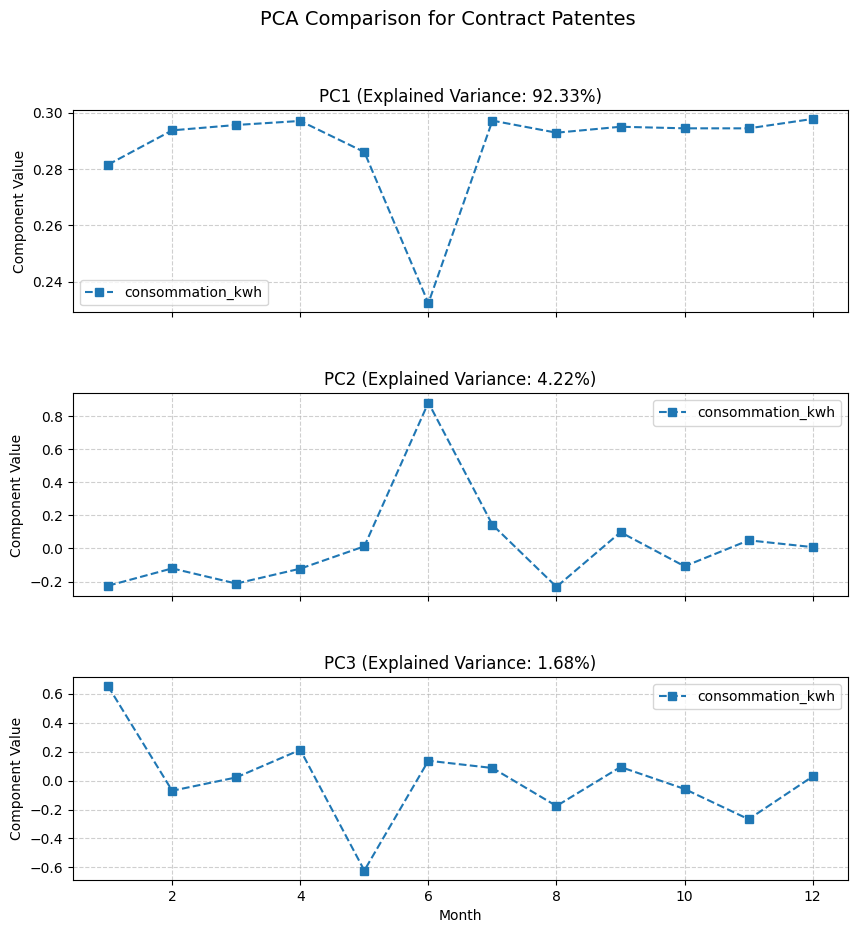

In [30]:
# Example plot for one contract
example_id = "Patentes"
plot_fpca_comparison(out_df, example_id)

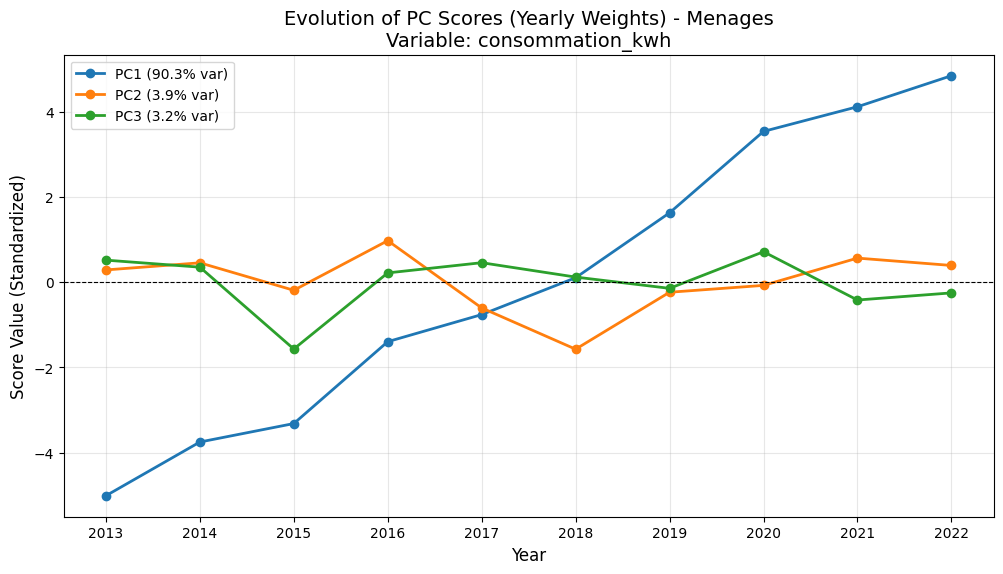

In [34]:
plot_pca_scores_evolution(df_regional, "Menages", variable="consommation_kwh")

# AR and PCA AR

In [ ]:
def select_best_model(results):
    """Select best model: lowest MAE with R² > threshold"""
    valid_results = [r for r in results if r['annual_r2'] >= R2_THRESHOLD]

    if not valid_results:
        return max(results, key=lambda x: x['annual_r2'])

    return min(valid_results, key=lambda x: x['annual_mae'])

In [58]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge

YEARS_DEFAULT = list(range(2018, 2024))  # 2018..2023
MONTHS = list(range(1, 13))              # 1..12


def strategy1_ultra_strict_loocv(monthly_matrix, years, n_pcs, lags_options, alphas, use_pca=True):
    """
    Ultra-strict LOOCV forecasting on a (years x 12) monthly matrix.

    If use_pca=True:
      - For each LOOCV fold, fit StandardScaler + PCA on training years only.
      - For each PC, train a Ridge AR model on lagged PC scores to predict the held-out year's PC score.
      - Reconstruct the 12-month curve via inverse_transform.

    If use_pca=False (AR-only):
      - For each month (1..12), train a Ridge AR model on lagged monthly values across years to predict
        the held-out year's monthly value (no PCA, no scaling of the target, X can be standardized per fold).

    Parameters:
      monthly_matrix : np.ndarray, shape (n_years, 12)
      years          : list[int], aligned to monthly_matrix rows
      n_pcs          : int, number of PCs (used only if use_pca=True)
      lags_options   : list[int], e.g. [1, 2, 3]
      alphas         : list[float], e.g. [0.1, 1.0, 10.0]
      use_pca        : bool

    Returns:
      results : list of dicts, each containing:
        - 'strategy' (string)
        - 'use_pca' (bool)
        - 'n_lags' (int)
        - 'pred_monthly_matrix' (np.ndarray, shape (n_folds, 12))
        - 'actual_monthly_matrix' (np.ndarray, shape (n_folds, 12))
        - 'valid_years' (np.ndarray, years corresponding to rows in matrices)
        - metrics from calculate_all_metrics(...)
    """
    results = []
    n_years = len(years)
    if monthly_matrix.shape != (n_years, 12):
        raise ValueError("monthly_matrix must have shape (len(years), 12)")

    for n_lags in lags_options:
        if n_years <= n_lags:
            # Not enough history to build lag features
            continue

        all_predictions = []
        all_actuals = []
        valid_years_list = []

        # LOOCV: leave out each year from index n_lags..n_years-1
        for test_idx in range(n_lags, n_years):
            # TRAIN indices (exclude test year)
            train_indices = [i for i in range(n_years) if i != test_idx]
            train_matrix = monthly_matrix[train_indices]   # shape (n_years-1, 12)

            if use_pca:
                # ---------------- PCA branch ----------------
                scaler_pca = StandardScaler()
                train_scaled = scaler_pca.fit_transform(train_matrix)  # standardize months across years
                n_allowed = min(n_pcs, train_scaled.shape[0], train_scaled.shape[1])
                pca = PCA(n_components=n_allowed).fit(train_scaled)
                train_pc_scores = pca.transform(train_scaled)  # (n_train_years, n_allowed)

                predicted_pcs = []
                for pc_idx in range(n_allowed):
                    # Build lagged features for training rows (in PC space)
                    X_train_lags = []
                    y_train = []

                    for i in range(n_lags, len(train_pc_scores)):
                        lags = train_pc_scores[i - n_lags:i, pc_idx]
                        X_train_lags.append(lags)
                        y_train.append(train_pc_scores[i, pc_idx])

                    X_train_lags = np.array(X_train_lags)
                    y_train = np.array(y_train)
                    if X_train_lags.size == 0:
                        predicted_pcs.append(0.0)
                        continue

                    # Nested LOOCV over alphas
                    best_alpha = alphas[0]
                    best_mae = float("inf")
                    for alpha in alphas:
                        fold_errors = []
                        for j in range(len(X_train_lags)):
                            X_tr = np.delete(X_train_lags, j, axis=0)
                            y_tr = np.delete(y_train, j)
                            X_val = X_train_lags[j:j+1]
                            y_val = y_train[j]

                            scaler_x = StandardScaler()
                            X_tr_scaled = scaler_x.fit_transform(X_tr)
                            X_val_scaled = scaler_x.transform(X_val)

                            model = Ridge(alpha=alpha)
                            model.fit(X_tr_scaled, y_tr)
                            pred = model.predict(X_val_scaled)[0]
                            fold_errors.append(abs(pred - y_val))

                        mae = float(np.mean(fold_errors)) if fold_errors else float("inf")
                        if mae < best_mae:
                            best_mae = mae
                            best_alpha = alpha

                    # Train final model on all training rows with best alpha
                    scaler_x = StandardScaler()
                    X_train_scaled = scaler_x.fit_transform(X_train_lags)

                    # Build test lag vector from previous n_lags years (PC projections from training-fitted PCA)
                    test_lag_indices = list(range(test_idx - n_lags, test_idx))
                    # Ensure we never touch the test year in lags (we didn't)
                    test_lags_pc = []
                    for lag_idx in test_lag_indices:
                        # Transform lag year into PC space using training scaler+PCA
                        lag_scaled = scaler_pca.transform(monthly_matrix[lag_idx:lag_idx+1])
                        lag_pc = pca.transform(lag_scaled)[0, pc_idx]
                        test_lags_pc.append(lag_pc)

                    if len(test_lags_pc) != n_lags:
                        predicted_pcs.append(0.0)
                        continue

                    X_test = np.array(test_lags_pc).reshape(1, -1)
                    X_test_scaled = scaler_x.transform(X_test)

                    model = Ridge(alpha=best_alpha)
                    model.fit(X_train_scaled, y_train)
                    pred_pc = model.predict(X_test_scaled)[0]
                    predicted_pcs.append(pred_pc)

                # Reconstruct 12-month curve from predicted PCs
                # If n_allowed < n_pcs, we simply used n_allowed PCs
                predicted_pcs = np.array(predicted_pcs).reshape(1, -1)
                reconstructed_std = pca.inverse_transform(predicted_pcs)           # back to standardized months
                reconstructed = scaler_pca.inverse_transform(reconstructed_std)[0] # back to original scale

            else:
                # ---------------- AR-only branch (no PCA) ----------------
                # For each month (12), build AR on lagged monthly values across years
                reconstructed = np.zeros(12, dtype=float)
                for m in range(12):
                    series = train_matrix[:, m]  # training years' month m values (length n_years-1)

                    # Build lagged design from "aligned" training timeline.
                    # We need to respect the gap at test_idx. Easiest is to form full series then drop test_idx row.
                    full_series = monthly_matrix[:, m]
                    # Indices for training in chronological order, excluding the test index
                    idx_train_chrono = [i for i in range(n_years) if i != test_idx]

                    # Build lagged rows using chronological training series
                    X_train_lags = []
                    y_train = []
                    for i in range(n_lags, len(idx_train_chrono)):
                        curr_idx = idx_train_chrono[i]
                        # we need the previous n_lags indices in the same training timeline
                        prev_idxs = idx_train_chrono[i - n_lags:i]
                        # If any of prev_idxs accidentally include the test_idx (they won't, by construction), skip
                        lags_vals = [full_series[p] for p in prev_idxs]
                        X_train_lags.append(lags_vals)
                        y_train.append(full_series[curr_idx])

                    X_train_lags = np.array(X_train_lags)
                    y_train = np.array(y_train)

                    if X_train_lags.size == 0:
                        reconstructed[m] = 0.0
                        continue

                    # Nested LOOCV (on training rows) to select alpha
                    best_alpha = alphas[0]
                    best_mae = float("inf")
                    for alpha in alphas:
                        fold_errors = []
                        for j in range(len(X_train_lags)):
                            X_tr = np.delete(X_train_lags, j, axis=0)
                            y_tr = np.delete(y_train, j)
                            X_val = X_train_lags[j:j+1]
                            y_val = y_train[j]

                            scaler_x = StandardScaler()
                            X_tr_scaled = scaler_x.fit_transform(X_tr)
                            X_val_scaled = scaler_x.transform(X_val)

                            model = Ridge(alpha=alpha)
                            model.fit(X_tr_scaled, y_tr)
                            pred = model.predict(X_val_scaled)[0]
                            fold_errors.append(abs(pred - y_val))

                        mae = float(np.mean(fold_errors)) if fold_errors else float("inf")
                        if mae < best_mae:
                            best_mae = mae
                            best_alpha = alpha

                    # Train final model on all training rows
                    scaler_x = StandardScaler()
                    X_train_scaled = scaler_x.fit_transform(X_train_lags)

                    # Build test features from the real previous n_lags years (chronological indices)
                    prev_real = list(range(test_idx - n_lags, test_idx))
                    test_lags_vals = [full_series[p] for p in prev_real]

                    if len(test_lags_vals) != n_lags:
                        reconstructed[m] = 0.0
                        continue

                    X_test = np.array(test_lags_vals).reshape(1, -1)
                    X_test_scaled = scaler_x.transform(X_test)

                    model = Ridge(alpha=best_alpha)
                    model.fit(X_train_scaled, y_train)
                    reconstructed[m] = model.predict(X_test_scaled)[0]

            all_predictions.append(reconstructed)
            all_actuals.append(monthly_matrix[test_idx])
            valid_years_list.append(years[test_idx])

        if len(all_predictions) == 0:
            continue

        all_predictions = np.array(all_predictions)  # (n_folds, 12)
        all_actuals = np.array(all_actuals)          # (n_folds, 12)

        actual_monthly = all_actuals.flatten()
        pred_monthly = all_predictions.flatten()
        actual_annual = all_actuals.sum(axis=1)
        pred_annual = all_predictions.sum(axis=1)

        metrics = calculate_all_metrics(actual_monthly, pred_monthly, actual_annual, pred_annual)

        results.append({
            'strategy': 'Strategy1_UltraStrict_ARonPC' if use_pca else 'Strategy1_UltraStrict_ARonly',
            'use_pca': use_pca,
            'n_lags': n_lags,
            'pred_monthly_matrix': all_predictions,
            'actual_monthly_matrix': all_actuals,
            'valid_years': np.array(valid_years_list),
            **metrics
        })

    return results


In [65]:
def run_analysis_for_cd(df, contrat):
    print(f"\n{'='*60}")
    print(f"ANALYZING: {contrat}")
    print(f"{'='*60}")

    monthly_matrix = create_monthly_matrix(df)
    years = np.array(sorted(df['année'].unique()))

    res_pca = strategy1_ultra_strict_loocv(
        monthly_matrix=monthly_matrix,
        years=years,
        n_pcs=3,
        lags_options=[2, 3],
        alphas=ALPHAS,
        use_pca=True
    )

    res_ar = strategy1_ultra_strict_loocv(
        monthly_matrix=monthly_matrix,
        years=years,
        n_pcs=3,                 # ignored if use_pca=False
        lags_options=[2, 3],
        alphas=ALPHAS,
        use_pca=False
    )
    

    # Select best
    all_results = res_ar + res_pca

    if len(all_results) == 0:
        print("⚠️  No valid results")
        return None

    best = select_best_model(all_results)

    # Print best model performance
    print(f"\n🏆 BEST MODEL: {best['strategy']}")
    print(f"   Config: lags={best['n_lags']}, use pca={best['use_pca']}", end='')

    print(f"\n   📊 ANNUAL METRICS:")
    print(f"      MAE:  {best['annual_mae']:,.2f} kWh")
    print(f"      MAPE: {best['annual_mape']:.2f}%")
    print(f"      R²:   {best['annual_r2']:.4f}")

    print(f"\n   📊 MONTHLY METRICS:")
    print(f"      MAE:  {best['monthly_mae']:,.2f} kWh")
    print(f"      MAPE: {best['monthly_mape']:.2f}%")
    print(f"      R²:   {best['monthly_r2']:.4f}")

    # 2023 predictions
    if 2023 in best['valid_years']:
        idx_2023 = np.where(best['valid_years'] == 2023)[0][0]
        actual_2023 = best['actual_monthly_matrix'][idx_2023]
        pred_2023 = best['pred_monthly_matrix'][idx_2023]

        print(f"\n   📅 2023 MONTHLY PREDICTIONS:")
        print(f"      Month | Actual (kWh) | Predicted (kWh) | Error (%)")
        print(f"      {'-'*55}")
        for m in range(12):
            error_pct = ((pred_2023[m] - actual_2023[m]) / actual_2023[m]) * 100
            print(f"      {m+1:2d}    | {actual_2023[m]:12,.0f} | {pred_2023[m]:15,.0f} | {error_pct:7.2f}%")

        annual_actual = actual_2023.sum()
        annual_pred = pred_2023.sum()
        annual_error_pct = ((annual_pred - annual_actual) / annual_actual) * 100
        print(f"      {'-'*55}")
        print(f"      TOTAL | {annual_actual:12,.0f} | {annual_pred:15,.0f} | {annual_error_pct:7.2f}%")

    return {
        'contrat': contrat,
        'best_model': best
    }


In [ ]:
contrat_ids = sorted(df['contrat'].unique())
all_results = []

for contrat in contrat_ids:
    df_contrat = df[df['contrat'] == contrat].copy()
    result = run_analysis_for_cd(
        df_contrat, 
        f"Contrat_{contrat}", 
    )
    if result:
        all_results.append(result)

# Annual ARIMA

In [96]:
import numpy as np
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA

In [140]:
import warnings
# Hide statsmodels convergence warnings
warnings.filterwarnings("ignore")

In [97]:
# --------------------------
# 3) Helper to evaluate one (p,d,q)
# --------------------------
def try_arima_forecast(train_series, test_len, order):
    """
    Fits ARIMA(order) on train_series and forecasts test_len steps.
    Returns (test_forecast_array, fitted_model).
    """
    model = ARIMA(
        train_series,
        order=order,
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    fitted = model.fit()
    fc = fitted.forecast(steps=test_len)
    return np.asarray(fc, dtype=float), fitted


def select_best_model(results):
    """Select best model using TEST metrics: lowest MAPE with R² > threshold; else fallback to highest R²."""
    valid_results = [r for r in results if r["metrics"]["test"]['R2'] >= R2_THRESHOLD]
    if not valid_results:
        return max(results, key=lambda x: x["metrics"]["test"]['R2'])
    return min(valid_results, key=lambda x: x["metrics"]["test"]['MAPE'])

In [ ]:
def arima_grid_search_by_entity(
    df,
    level,
    target,
    p_grid=(2, 3),
    d_grid=(0, 1),
    q_grid=(2, 3),
    min_points: int = 5,
    test_horizon: int = 2,
    verbose: bool = False,
):
    all_results = []

    for entity, g in df.groupby(level):
        # Build annual time series for the chosen TARGET (sum across any remaining grouping cols)
        ts = (
            g.groupby("annee")[target]
             .sum()
             .sort_index()
        )

        # Need enough points to train/test
        if len(ts) < max(min_points, test_horizon + 1):  # ensure at least 1 train point
            all_results.append({
                "entity": entity,
                "target": target,
                "note": f"Skipped: only {len(ts)} annual points.",
            })
            if verbose:
                print(f"[{entity}] order={order}: train too short for differencing d={d}")
            continue

        # Train/Test split: last `test_horizon` years are test
        train = ts.iloc[:-test_horizon]
        test = ts.iloc[-test_horizon:]
        test_years = test.index.to_list()
        test_values = test.values.astype(float)

        train_y = train.values.astype(float)

        # Grid search ARIMA
        candidates = []
        for p in p_grid:
            for d in d_grid:
                for q in q_grid:
                    order = (p, d, q)
                    # Skip degenerate order if train too short vs. differencing
                    if len(train) <= d:
                        if verbose:
                            print(f"[{entity}] order={order}: train too short for differencing d={d}")
                        continue
                    try:
                        fc_test, fitted = try_arima_forecast(train, len(test), order)
                        pred_train = fitted.predict(
                            start=train.index[0], # d + p
                            end=train.index[-1],
                            dynamic=False
                        )
                        pred_train = np.asarray(pred_train, dtype=float)

                        train_metrics = {
                            "MAE": float(mean_absolute_error(train_y, pred_train)),
                            "MAPE": float(custom_mean_absolute_percentage_error(train_y, pred_train)) * 100,
                            "R2": float(r2_score(train_y, pred_train)),
                        }

                        test_metrics = {
                            "MAE": float(mean_absolute_error(test_values, fc_test)),
                            "MAPE": float(custom_mean_absolute_percentage_error(test_values, fc_test)) * 100,
                            "R2": float(r2_score(test_values, fc_test)),
                        }

                        candidates.append({
                            "order": order,
                            "metrics": {
                                "train": train_metrics,
                                "test": test_metrics,
                            },
                            "forecast": np.asarray(fc_test, dtype=float),
                            "model_": fitted,
                        })
                    except Exception as e:
                        if verbose:
                            print(f"[{entity}] order={order} error: {e}")
                        continue

        if not candidates:
            all_results.append({
                "entity": entity,
                "target": target,
                "note": "No ARIMA models could be fit.",
            })
            if verbose:
                print(f"No ARIMA models could be fit.")
            continue

        best = select_best_model(candidates)

        # Package succinct result (avoid storing full model object if size matters)
        best_result = {
            "entity": entity,
            "target": target,
            "best_order": best["order"],
            "metrics": best["metrics"],
            "test_years": test_years,
            "forecast": np.asarray(best["forecast"], dtype=float).tolist(),
            "model": best["model_"],  # beware: not JSON-serializable
        }
        all_results.append(best_result)

    return all_results


In [ ]:
def get_results_df(all_results):
    summary_rows = []
    for item in all_results:
        # Many ARIMA results store metrics as {"train": {...}, "test": {...}}
        if "best_order" in item:
            metrics = item.get("metrics", {})
            train_m = metrics.get("train", {}) or {}
            test_m = metrics.get("test", {}) or {}

            # Keep backward-compatible top-level MAE/MAPE/R2 as the test metrics
            summary_rows.append({
                "entity": item.get("entity"),
                "target": item.get("target"),
                "best_order": item.get("best_order"),
                # explicit train metrics
                "MAE_train": train_m.get("MAE"),
                "MAPE_train": train_m.get("MAPE"),
                "R2_train": train_m.get("R2"),
                # explicit test metrics
                "MAE_test": test_m.get("MAE"),
                "MAPE_test": test_m.get("MAPE"),
                "R2_test": test_m.get("R2"),
                "test_years": item.get("test_years"),
            })
        else:
            # keep old behavior for skipped/failed items
            print("best_order is not in item")
            summary_rows.append({
                "entity": item.get("entity"),
                "target": item.get("target"),
                "best_order": None,
                "MAE_train": None,
                "MAPE_train": None,
                "R2_train": None,
                "MAE_test": None,
                "MAPE_test": None,
                "R2_test": None,
                "test_years": None,
                "note": item.get("note"),
            })

    # sort by test MAPE then test MAE (NA last)
    results_df = pd.DataFrame(summary_rows).sort_values(by=["MAPE_test", "MAE_test"], na_position="last")
    return results_df

## Per contrat

In [77]:
df_yearly = (
    df
    .groupby(["partenaire", "contrat", "activite", "secteur", "annee"], as_index=False)[["ventes", "consommation"]]
    .sum()
)

In [18]:
df_yearly.head()

,partenaire,contrat,activite,secteur,annee,ventes,consommation
0,ACWA POWER KHALLADI,6434280,"PRODUCTION ET DISTTRIBUTION D'ELECTRICITE, DE ...",PROD. ET DIST. D'ÉLECTRICITÉ,2013,0.0,0.0
1,ACWA POWER KHALLADI,6434280,"PRODUCTION ET DISTTRIBUTION D'ELECTRICITE, DE ...",PROD. ET DIST. D'ÉLECTRICITÉ,2014,0.0,0.0
2,ACWA POWER KHALLADI,6434280,"PRODUCTION ET DISTTRIBUTION D'ELECTRICITE, DE ...",PROD. ET DIST. D'ÉLECTRICITÉ,2015,0.0,0.0
3,ACWA POWER KHALLADI,6434280,"PRODUCTION ET DISTTRIBUTION D'ELECTRICITE, DE ...",PROD. ET DIST. D'ÉLECTRICITÉ,2016,0.0,0.0
4,ACWA POWER KHALLADI,6434280,"PRODUCTION ET DISTTRIBUTION D'ELECTRICITE, DE ...",PROD. ET DIST. D'ÉLECTRICITÉ,2017,0.0,0.0


In [60]:
df_yearly.isna().sum()

partenaire      0
contrat         0
activite        0
secteur         0
annee           0
ventes          0
consommation    0
dtype: int64

In [ ]:
# --------------------------
# CONFIG
# --------------------------
TARGET = "consommation"            # change to "consommation" when needed
P_GRID = [2]           # AR terms
D_GRID = [0, 1]              # differencing
Q_GRID = [2, 3]           # MA terms
MIN_POINTS = 5               # minimum annual points required to try ARIMA
level = "contrat"


all_results = arima_grid_search_by_entity(df, level, TARGET, P_GRID, D_GRID, Q_GRID, MIN_POINTS)

In [ ]:
results_df = get_results_df(all_results)

best_order is not in item
best_order is not in item


## Per Client

In [87]:
df_client = df.groupby(["partenaire", "annee"], as_index=False)[["ventes", "consommation"]].sum()

In [129]:
# --------------------------
# CONFIG
# --------------------------
TARGET = "consommation"            # change to "consommation" when needed
P_GRID = [2, 3]           # AR terms
D_GRID = [0, 1]              # differencing
Q_GRID = [2, 3]           # MA terms
MIN_POINTS = 5               # minimum annual points required to try ARIMA

level = "partenaire"



# all_results = arima_grid_search_by_entity(df, level, TARGET, P_GRID, D_GRID, Q_GRID, MIN_POINTS, verbose=True)

In [139]:
dff = df[df["partenaire"] == "CIMENTS DU MAROC"]
all_results = arima_grid_search_by_entity(dff, level, TARGET, P_GRID, D_GRID, Q_GRID, MIN_POINTS, verbose=True)

In [145]:
all_results[0]["forecast"]

[280905.1495255449, 281584.2005473134]

In [102]:
results_df = get_results_df(all_results)

best_order is not in item


In [132]:
len(results_df[results_df["MAPE_test"]<=5])

13

In [183]:
results_df.drop(columns = ["MAE","MAPE","R2"], inplace = True)

In [184]:
results_df.to_excel("partenaire_output.xlsx", index = False)

<Axes: xlabel='R2_train', ylabel='Count'>

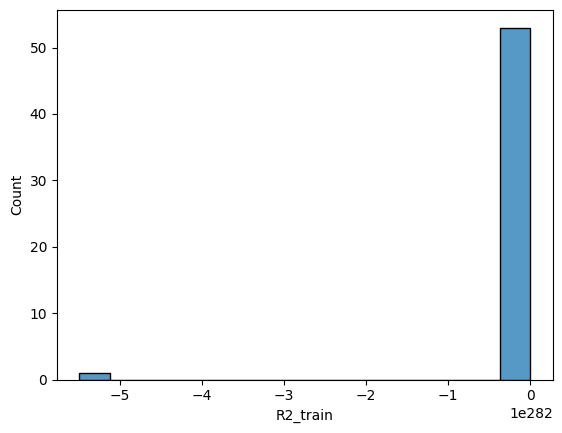

In [117]:
sns.histplot(results_df["R2_train"])

In [149]:
# results_df

In [146]:
results_df[results_df["R2_train"] >= 0]

,entity,target,best_order,MAE_train,MAPE_train,R2_train,MAE_test,MAPE_test,R2_test,MAE,MAPE,R2,test_years,note
15,CIMENTS DU MAROC,consommation,"(3, 0, 3)",25217.443758,9.519934,0.0,6830.883036,2.513794,-2.972814,6830.883036,2.513794,-2.972814,"[2022, 2023]",NaN
38,OCP SA,consommation,"(2, 0, 2)",219678.616479,27.895111,0.0,34628.844368,3.264029,-10.344127,34628.844368,3.264029,-10.344127,"[2022, 2023]",NaN
19,COMPAGNIE MINIERE DES GUEMASSA,consommation,"(3, 0, 2)",14395.626408,23.848242,0.0,3346.960407,4.261238,-1.957267,3346.960407,4.261238,-1.957267,"[2022, 2023]",NaN
12,Boujdour Wind Farm,consommation,"(2, 1, 2)",0.000000,0.000000,1.0,126.870000,50.000000,-1.000000,126.870000,50.000000,-1.000000,"[2022, 2023]",NaN
24,ESSAOUIRA WIND FARM,consommation,"(2, 1, 2)",0.000000,0.000000,1.0,126.875000,50.000000,-1.000000,126.875000,50.000000,-1.000000,"[2022, 2023]",NaN
10,AOM MAROC,consommation,"(2, 1, 2)",0.000000,0.000000,1.0,534.972500,50.000000,-1.000000,534.972500,50.000000,-1.000000,"[2022, 2023]",NaN
34,MINISTERE DE L'EQUIPEMENT ET DE L'EAU - MEE,consommation,"(2, 1, 2)",0.000000,0.000000,1.0,20528.336000,50.000000,-1.000000,20528.336000,50.000000,-1.000000,"[2022, 2023]",NaN
37,NOVACIM,consommation,"(2, 1, 2)",0.000000,0.000000,1.0,21845.215000,100.000000,-1.073551,21845.215000,100.000000,-1.073551,"[2022, 2023]",NaN


In [153]:
results_df[results_df["R2_test"] >= 0]

,entity,target,best_order,MAE_train,MAPE_train,R2_train,MAE_test,MAPE_test,R2_test,MAE,MAPE,R2,test_years,note
41,ONEE_BRANCHE EAU,consommation,"(2, 0, 2)",2.054095e+125,1.340384e+122,-3.240065e+242,411.670990,2.195749e-01,0.991650,411.670990,2.195749e-01,0.991650,"[2022, 2023]",NaN
32,MAGHREB STEEL,consommation,"(3, 1, 3)",1.111191e+05,4.448532e+01,-3.523826e-01,9623.681477,2.088393e+00,0.893484,9623.681477,2.088393e+00,0.893484,"[2022, 2023]",NaN
25,FONEX ALUMINIUM,consommation,"(2, 0, 3)",1.588326e+03,3.600418e+01,-3.424934e-03,271.804588,4.713279e+00,0.131125,271.804588,4.713279e+00,0.131125,"[2022, 2023]",NaN
13,CELLULOSE DU MAROC,consommation,"(2, 0, 2)",3.816657e+80,7.309537e+97,-1.019646e+155,109.111968,4.913966e+19,0.000000,109.111968,4.913966e+19,0.000000,"[2022, 2023]",NaN
16,COMPAGNIE EOLIENNE DU DETROIT,consommation,"(2, 0, 2)",9.155410e+01,2.065437e+19,-2.251196e-06,216.006945,9.728088e+19,0.000000,216.006945,9.728088e+19,0.000000,"[2022, 2023]",NaN
50,SEPCOIII MOROCCO BRANCH,consommation,"(2, 0, 2)",6.363805e+02,1.102666e+20,-2.086899e-08,492.633994,2.218626e+20,0.000000,492.633994,2.218626e+20,0.000000,"[2022, 2023]",NaN
54,STE DES FONDERIES DE PLOMB ZELLIDJA,consommation,"(2, 0, 2)",7.787604e+02,1.429952e+20,-5.448371e-04,694.343522,3.127045e+20,0.000000,694.343522,3.127045e+20,0.000000,"[2022, 2023]",NaN


In [ ]:
result

## Plots

<Axes: xlabel='annee', ylabel='consommation'>

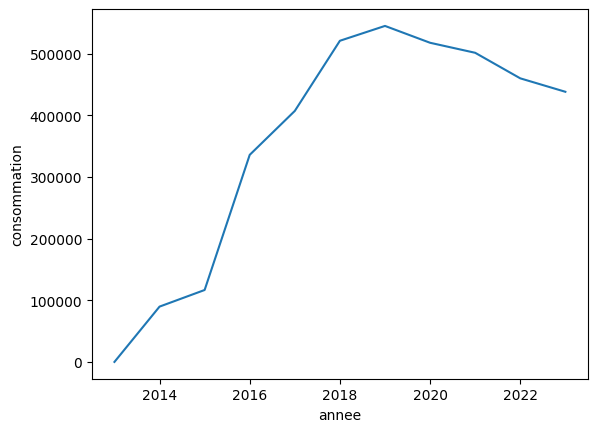

In [66]:
contrat = 4483825 # df_yearly["contrat"].unique()[0]
sns.lineplot(df_yearly[df_yearly["contrat"] == contrat], x = "annee", y = "consommation")

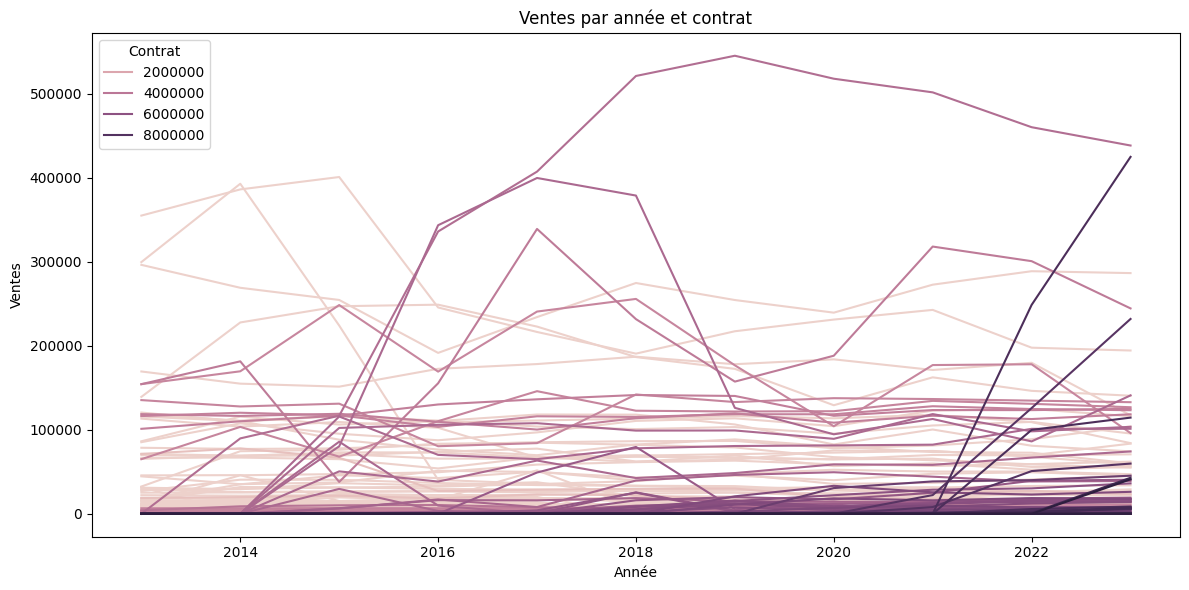

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))  # make the figure larger

sns.lineplot(
    data=df_yearly,
    x="annee",
    y="consommation",
    hue="contrat"  # color by contract
)

plt.title("Ventes par année et contrat")
plt.xlabel("Année")
plt.ylabel("Ventes")
plt.legend(title="Contrat")
plt.tight_layout()
plt.show()


In [75]:
def get_ventes_cons_corr(contrat):
    df_c = df_yearly[df_yearly["contrat"] == contrat]
    if len(df_c) < 2:
        return np.nan
    return df_c["ventes"].corr(df_c["consommation"])

In [77]:
corr_results = []
for contrat in df_yearly["contrat"].unique():
    corr = get_ventes_cons_corr(contrat)
    corr_results.append({
        "contrat": contrat,
        "ventes_consommation_corr": corr
    })
corr_df = pd.DataFrame(corr_results)

<Axes: xlabel='ventes_consommation_corr', ylabel='Count'>

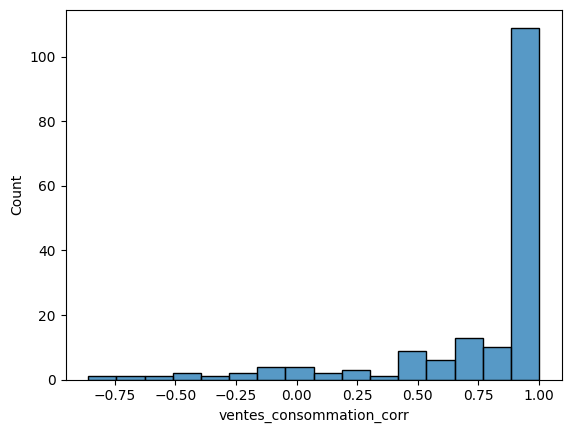

In [79]:
sns.histplot(corr_df["ventes_consommation_corr"])

In [ ]:
def plot_corr_masked(corr_matrix, threshold=0.85):
    """
    Plot a correlation matrix, masking correlations below the threshold in absolute value.
    
    Parameters
    ----------
    corr_matrix : pd.DataFrame
        A pandas correlation matrix.
    threshold : float, optional
        Minimum absolute correlation to display. Values below are masked. Default is 0.85.
    """
    # Create mask for correlations with |corr| < threshold
    mask = corr_matrix.abs() < threshold

    # Set up the plot
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        corr_matrix,
        mask=mask,
        cmap="coolwarm",
        center=0,
        annot=True,
        fmt=".2f",
        linewidths=0.5,
        cbar_kws={"shrink": 0.8},
    )
    plt.title(f"Correlation matrix (|corr| ≥ {threshold})", fontsize=14)
    plt.tight_layout()
    plt.show()

def get_most_correlated(corr_matrix, contrat_id, top_n=None, threshold=None):
    """
    Given a correlation matrix and a contract ID, return the most correlated contracts.

    Parameters
    ----------
    corr_matrix : pd.DataFrame
        A correlation matrix (contracts as both index and columns).
    contrat_id : str
        The ID of the contract for which to find correlations.
    top_n : int, optional
        Number of top correlated contracts to return (sorted by absolute correlation).
        If None, all above the threshold (if provided) are returned.
    threshold : float, optional
        Minimum absolute correlation value to include. If None, no filtering.

    Returns
    -------
    pd.DataFrame
        A DataFrame with 'contrat' and 'correlation' columns.
    """
    if contrat_id not in corr_matrix.columns:
        raise ValueError(f"Contract '{contrat_id}' not found in correlation matrix.")

    # Get correlation series for that contract
    corr_series = corr_matrix[contrat_id].drop(contrat_id)  # drop self-correlation

    # Apply threshold filter if requested
    if threshold is not None:
        corr_series = corr_series[corr_series.abs() >= threshold]

    # Sort by absolute correlation (descending)
    corr_series = corr_series.reindex(corr_series.abs().sort_values(ascending=False).index)

    # Keep top N if specified
    if top_n is not None:
        corr_series = corr_series.head(top_n)

    # Return as a DataFrame for convenience
    return corr_series.reset_index().rename(columns={'index': 'contrat', contrat_id: 'correlation'})

def get_top_correlations(corr_matrix, threshold=0.85):
    """
    Flatten correlation matrix and keep only pairs with |corr| >= threshold.
    """
    corr_matrix = corr_matrix.copy()
    # Give distinct names to index/columns to avoid duplicate column names
    corr_matrix = corr_matrix.rename_axis(index='contrat_1', columns='contrat_2')
    corr_pairs = (
        corr_matrix.stack()
        .reset_index()
        .rename(columns={'level_0': 'contrat_1', 'level_1': 'contrat_2', 0: 'correlation'})
    )
    # Remove duplicates and self-correlations
    corr_pairs = corr_pairs[corr_pairs['contrat_1'] < corr_pairs['contrat_2']]
    # Filter by threshold
    corr_pairs = corr_pairs[corr_pairs['correlation'].abs() >= threshold]
    # Sort by absolute correlation
    corr_pairs = corr_pairs.reindex(corr_pairs['correlation'].abs().sort_values(ascending=False).index)
    return corr_pairs



In [27]:
# --- For ventes ---
ventes_pivot = df_yearly.pivot_table(
    index='annee', columns='contrat', values='ventes'
)

ventes_corr = ventes_pivot.corr()


In [28]:

# --- For consommation ---
cons_pivot = df_yearly.pivot_table(
    index='annee', columns='contrat', values='consommation'
)

cons_corr = cons_pivot.corr()

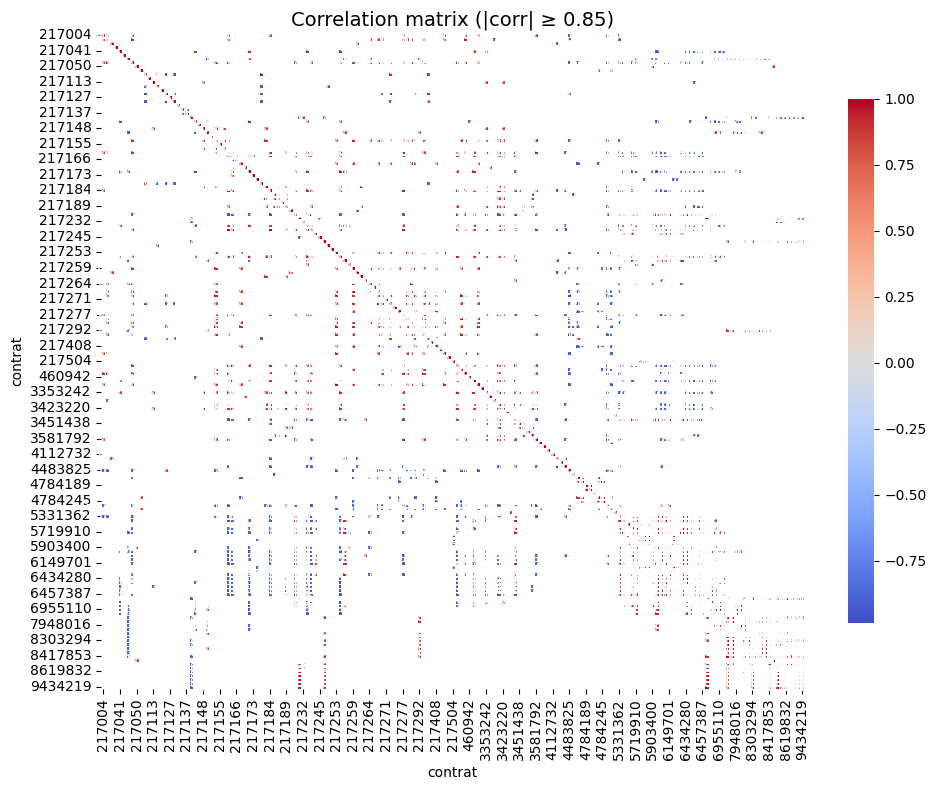

In [51]:
plot_corr_masked(cons_corr, threshold=0.85)

In [52]:
get_top_correlations(cons_corr)

,contrat_1,contrat_2,correlation
28051,8719991,9078678,1.000000
28052,8719991,9352901,1.000000
28221,9078678,9352901,1.000000
28222,9078678,9434219,1.000000
28053,8719991,9434219,1.000000
...,...,...,...
16191,3419416,6149701,-0.850301
13003,217292,8330934,0.850271
447,217014,4151460,-0.850159
14656,460884,5022460,-0.850108


c:\Users\Soufiane.AITELAOUAD\dev.cleverlytics\venvs\.onee\Lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
c:\Users\Soufiane.AITELAOUAD\dev.cleverlytics\venvs\.onee\Lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


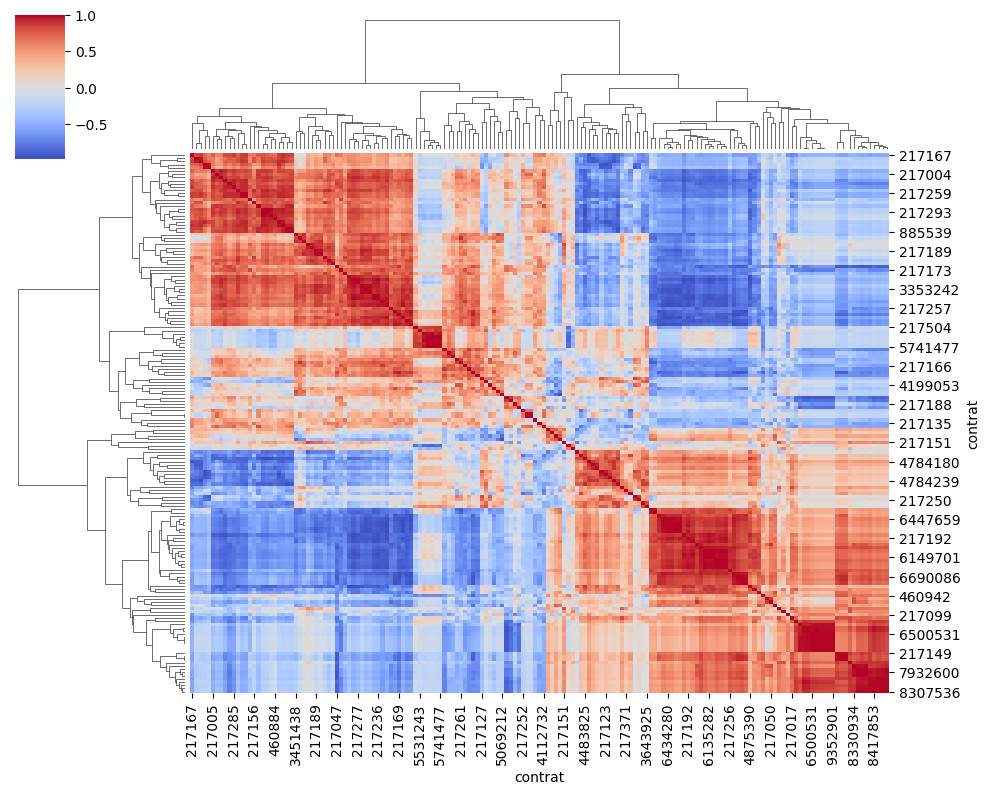

In [53]:
sns.clustermap(cons_corr, cmap='coolwarm', center=0, figsize=(10, 8))

In [20]:
finished_contrats = []
for contrat in df["contrat"].unique():
    df_c = df[df["contrat"] == contrat]
    if df_c[df_c["annee"] >= 2021]["consommation"].sum() == 0:
        finished_contrats.append(contrat)

In [56]:
len(finished_contrats)

20

In [40]:
just_starting_contrats = []
for contrat in df["contrat"].unique():
    if contrat in finished_contrats:
        continue
    
    if df[(df["contrat"] == contrat) & (df["annee"] == 2021)]["consommation"].sum() == 0:
        just_starting_contrats.append(contrat)


In [57]:
len(just_starting_contrats)

11

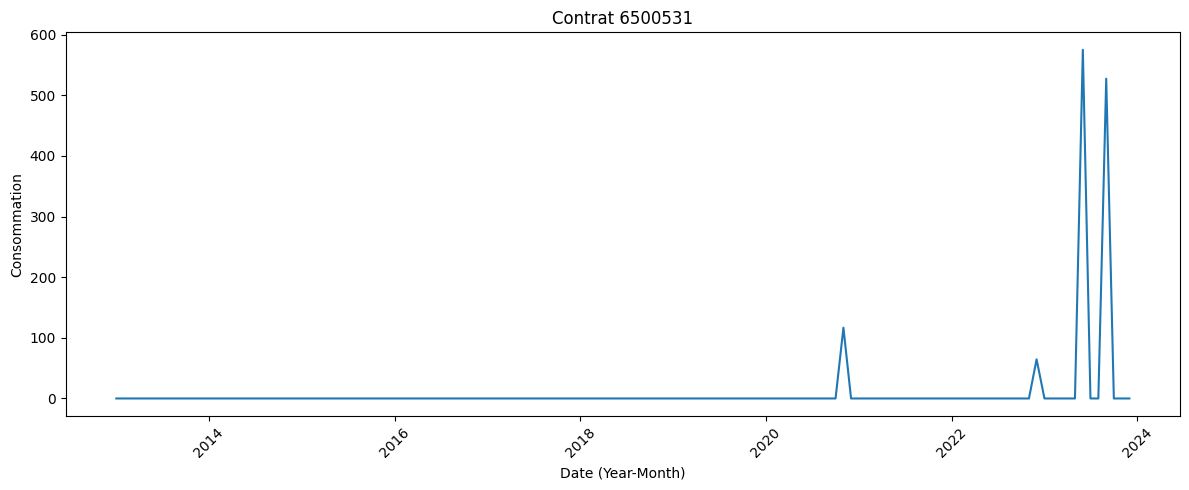

In [55]:
plot_var_over_time(df, contrat = 6500531)

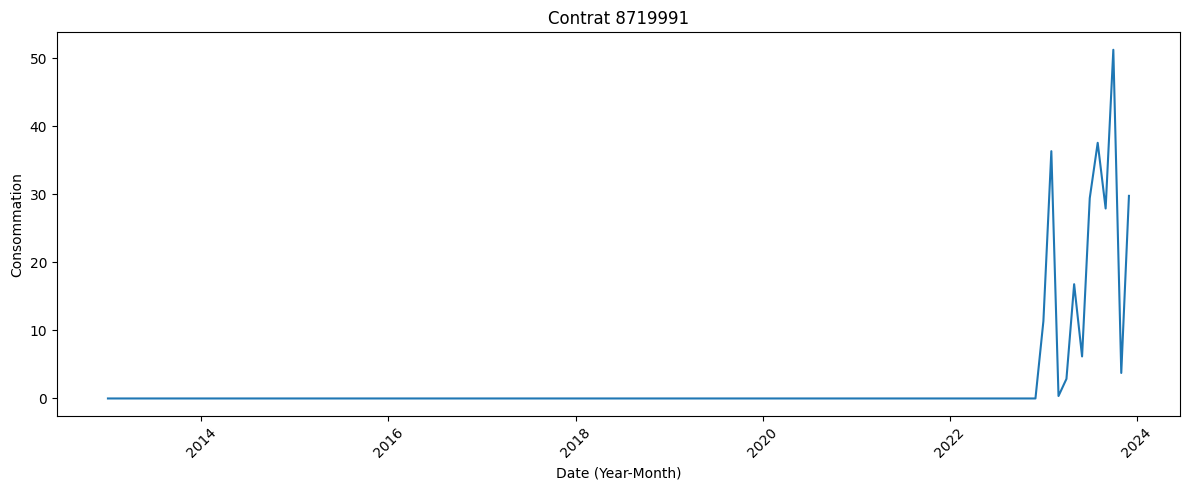

In [68]:
plot_var_over_time(df, contrat = 8719991)

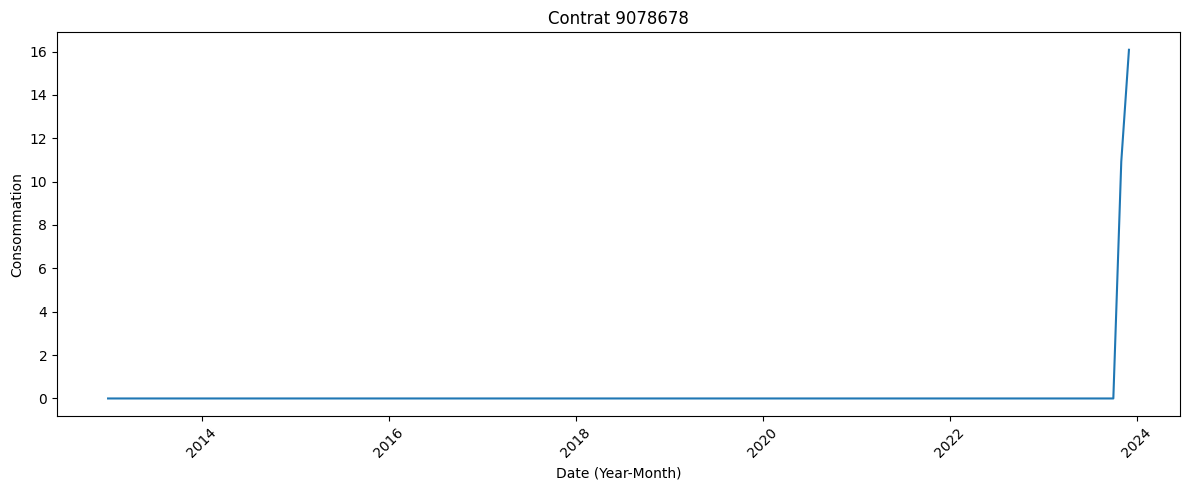

In [69]:
plot_var_over_time(df, contrat = 9078678)